In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import matplotlib.gridspec as gridspec
from scipy import spatial
from tqdm import *
import random
import os
import subprocess

cdm = h5py.File('Data/COLOR_CDM_DM_subHaloes_z0.00_v2.hdf5', 'r')
wdm = h5py.File('Data/COLOR_WDM_DM_subHaloes_z0.00_v2.hdf5', 'r')

cdm_galaxy = h5py.File('Data\COLOR_CDM_galaxies_z0.00.hdf5', 'r')
wdm_galaxy = h5py.File('Data\COLOR_WDM_galaxies_z0.00.hdf5', 'r')

print(cdm,wdm)

<HDF5 file "COLOR_CDM_DM_subHaloes_z0.00_v2.hdf5" (mode r)> <HDF5 file "COLOR_WDM_DM_subHaloes_z0.00_v2.hdf5" (mode r)>


# Find all galaxies that are as heavy as the Milky Way
### Access the masses and positions of CDM and WDM galaxies

In [2]:
# Access mass/position for wdm/cdm
print(list(cdm_galaxy.keys()),list(wdm_galaxy.keys()))

cdm_galaxy_color = cdm_galaxy['Colour'][:]
cdm_galaxy_position = cdm_galaxy['GalaxyPos'][:]
cdm_galaxy_mass = cdm_galaxy['StellarMass'][:]

wdm_galaxy_color = wdm_galaxy['Colour'][:]
wdm_galaxy_position = wdm_galaxy['GalaxyPos'][:]
wdm_galaxy_mass = wdm_galaxy['StellarMass'][:]

cdm_galaxy_color, cdm_galaxy_position, cdm_galaxy_mass, wdm_galaxy_color, wdm_galaxy_position, wdm_galaxy_mass

['Colour', 'GalaxyPos', 'HaloRvir', 'HostHaloMass', 'IsCentral', 'StellarMass'] ['Colour', 'GalaxyPos', 'HaloRvir', 'HostHaloMass', 'IsCentral', 'StellarMass']


(array([0.3074894 , 0.59537411, 0.59701824, ..., 0.59878778, 0.59881878,
        0.5967443 ]),
 array([[17.43208122, 80.25539398, 54.00876999],
        [17.43210793, 80.22522736, 53.97425079],
        [17.43374443, 80.27178955, 54.02692413],
        ...,
        [85.55805969,  1.73876286, 65.28675079],
        [52.84350586, 10.11826706, 16.42269516],
        [55.3265419 , 34.21372986, 28.35575867]]),
 array([1.86803984e+08, 3.18429395e+04, 4.78547754e+03, ...,
        5.03134871e+00, 2.88395190e+00, 2.04510657e+03]),
 array([0.29522324, 0.29758644, 0.5930109 , ..., 0.59763646, 0.59827816,
        0.59777474]),
 array([[17.61932182, 79.06235504, 52.68593979],
        [18.65647697, 80.58162689, 52.30108261],
        [18.58250046, 80.91363525, 52.45199203],
        ...,
        [78.62889862, 83.76999664, 61.69128036],
        [97.51596069, 36.17467499, 37.83997726],
        [ 6.65006733, 48.75699997, 51.62447739]]),
 array([3.12070700e+06, 4.30492600e+06, 8.09484188e+05, ...,
        1.59

### Find all central galaxies within the mass range $2-6*10^{10}$ M$_{\odot}$

In [3]:
# get the indices
cdm_MW_galaxy_ind = np.where((cdm_galaxy_mass>2*10**10) & (cdm_galaxy_mass<6*10**10) & (cdm_galaxy['IsCentral'][:]==1))[0]
wdm_MW_galaxy_ind = np.where((wdm_galaxy_mass>2*10**10) & (wdm_galaxy_mass<6*10**10) & (wdm_galaxy['IsCentral'][:]==1))[0]

In [4]:
# get the positions
cdm_MW_galaxy_position = cdm_galaxy_position[cdm_MW_galaxy_ind]
wdm_MW_galaxy_position = wdm_galaxy_position[wdm_MW_galaxy_ind]

### Set a minimum mass of galaxies to search through

In [5]:
# get the indices
m_min=0
cdm_galaxy_filtered_ind = np.where(cdm_galaxy_mass > m_min)[0]
wdm_galaxy_filtered_ind = np.where(wdm_galaxy_mass > m_min)[0]

In [6]:
# get the positions
cdm_galaxy_position_filtered = cdm_galaxy_position[cdm_galaxy_filtered_ind]
wdm_galaxy_position_filtered = wdm_galaxy_position[wdm_galaxy_filtered_ind]

### Find all the galaxies within 3 Mpc of each MW-sized galaxy

In [7]:
# create the trees
cdm_tree = spatial.cKDTree(cdm_galaxy_position_filtered)
wdm_tree = spatial.cKDTree(wdm_galaxy_position_filtered)

In [8]:
# create an empty array for the indices of the galaxies
cdm_3Mpc_sphere_galaxy = []

# iterate through each MW-sized galaxy
for i in trange(len(cdm_MW_galaxy_position)):
    
    # find the indices of all galaxies in a 3 Mpc radius around each MW-sized galaxy
    ind = cdm_tree.query_ball_point(cdm_MW_galaxy_position[i], 3)
    
    # record the indices for each MW-sized galaxy
    cdm_3Mpc_sphere_galaxy.append(ind)

100%|██████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 2948.04it/s]


In [9]:
# create an empty array for the indices of the galaxies
wdm_3Mpc_sphere_galaxy = []

# iterate through each MW-sized galaxy
for i in trange(len(wdm_MW_galaxy_position)):
    
    # find the indices of all galaxies in a 3 Mpc radius around each MW-sized galaxy
    ind = wdm_tree.query_ball_point(wdm_MW_galaxy_position[i], 3)
    
    # record the indices for each MW-sized galaxy
    wdm_3Mpc_sphere_galaxy.append(ind)

100%|██████████████████████████████████████████████████████████████████████████████| 407/407 [00:00<00:00, 4513.57it/s]


### Find all the galaxies within the Virial Radius of each MW-sized galaxy

In [10]:
# create an empty array for the indices of the galaxies
cdm_VR_sphere_galaxy = []

# iterate through each MW-sized galaxy
for i in trange(len(cdm_MW_galaxy_position)):
    
    # find the indices of all galaxies within the virial radius of each MW-sized galaxy's host halo
    ind = cdm_tree.query_ball_point(cdm_MW_galaxy_position[i], cdm_galaxy['HaloRvir'][:][cdm_MW_galaxy_ind[i]])
    
    # record the indices for each MW-sized galaxy
    cdm_VR_sphere_galaxy.append(ind)

100%|████████████████████████████████████████████████████████████████████████████████| 456/456 [00:05<00:00, 90.77it/s]


In [11]:
# create an empty array for the indices of the galaxies
wdm_VR_sphere_galaxy = []

# iterate through each MW-sized galaxy
for i in trange(len(wdm_MW_galaxy_position)):
    
    # find the indices of all galaxies within the virial radius of each MW-sized galaxy's host halo
    ind = wdm_tree.query_ball_point(wdm_MW_galaxy_position[i], wdm_galaxy['HaloRvir'][:][wdm_MW_galaxy_ind[i]])
    
    # record the indices for each MW-sized galaxy
    wdm_VR_sphere_galaxy.append(ind)

100%|███████████████████████████████████████████████████████████████████████████████| 407/407 [00:02<00:00, 200.09it/s]


### Find the positions of galaxies in between the virial radius of each halo and 3 Mpc

In [12]:
# create an empty array for the indices of the galaxies that are not within the virial radius of each halo
cdm_shell_galaxy = []

# iterate through each MW-sized galaxy
for i in trange(len(cdm_3Mpc_sphere_galaxy)):
    
    # find the indices of all galaxies that are not within the virial radius of each halo
    ind = [j for j in cdm_3Mpc_sphere_galaxy[i] if j not in cdm_VR_sphere_galaxy[i]]
    
    # record the indices for each MW-sized galaxy
    cdm_shell_galaxy.append(cdm_galaxy_position[cdm_galaxy_filtered_ind][ind])

100%|████████████████████████████████████████████████████████████████████████████████| 456/456 [00:34<00:00, 13.13it/s]


In [13]:
# create an empty array for the indices of the galaxies that are not within the virial radius of each halo
wdm_shell_galaxy = []

# iterate through each MW-sized galaxy
for i in trange(len(wdm_3Mpc_sphere_galaxy)):
    
    # find the indices of all galaxies that are not within the virial radius of each halo
    ind = [j for j in wdm_3Mpc_sphere_galaxy[i] if j not in wdm_VR_sphere_galaxy[i]]
    
    # record the indices for each MW-sized galaxy
    wdm_shell_galaxy.append(wdm_galaxy_position[wdm_galaxy_filtered_ind][ind])

100%|████████████████████████████████████████████████████████████████████████████████| 407/407 [00:12<00:00, 32.45it/s]


# Find all halos that are as heavy as the Milky Way
### Access the masses and positions of CDM and WDM halos

In [14]:
# Access mass/position for wdm/cdm
print(list(cdm.keys()),list(wdm.keys()))

cdm_mass = cdm['SubhaloMass'][:]
cdm_position = cdm['SubhaloPos'][:]

wdm_mass = wdm['SubhaloMass'][:]
wdm_position = wdm['SubhaloPos'][:]

cdm_mass, cdm_position, wdm_mass, wdm_position

['IsCentral', 'R200', 'SubhaloMass', 'SubhaloPos'] ['IsCentral', 'R200', 'SubhaloMass', 'SubhaloPos']


(array([1.87617493e+14, 1.84468594e+14, 6.89978024e+13, ...,
        1.76011232e+08, 1.76011232e+08, 1.76011232e+08]),
 array([[10.93832207, 81.23078918, 54.77935028],
        [17.94562721, 79.86347961, 53.3843956 ],
        [15.62266159, 78.18474579, 52.83857346],
        ...,
        [ 1.47748184,  3.54455233, 99.53264618],
        [99.32190704,  2.56014371,  2.57368279],
        [99.0621109 ,  4.18381071,  2.89533401]]),
 array([1.89941540e+14, 1.86912732e+14, 6.83256610e+13, ...,
        1.76011232e+08, 1.76011232e+08, 1.76011232e+08]),
 array([[1.80150642e+01, 7.98655701e+01, 5.34328232e+01],
        [1.09048624e+01, 8.12610779e+01, 5.48179703e+01],
        [1.56323385e+01, 7.81665344e+01, 5.28157997e+01],
        ...,
        [6.02296066e+00, 5.05078554e+00, 9.79758301e+01],
        [5.75055540e-01, 3.26677370e+00, 3.52767438e-01],
        [2.07897183e-03, 3.23730040e+00, 9.97708917e-01]]))

### Find all central halos within the mass range $0.8-2*10^{12}$ M$_{\odot}$

In [15]:
# get the indices
cdm_MW_ind = np.where((cdm_mass>0.8*10**12) & (cdm_mass<2*10**12) & (cdm['IsCentral'][:]==1))[0]
wdm_MW_ind = np.where((wdm_mass>0.8*10**12) & (wdm_mass<2*10**12) & (wdm['IsCentral'][:]==1))[0]

len(cdm_MW_ind), len(wdm_MW_ind)

(1057, 1065)

In [16]:
# get the positions
cdm_MW_position = cdm_position[cdm_MW_ind]
wdm_MW_position = wdm_position[wdm_MW_ind]

### Find all the galaxies within 3 Mpc of each MW-sized halo

In [17]:
# create an empty array for the indices of the galaxies
cdm_3Mpc_sphere = []

# iterate through each MW-sized galaxy
for i in trange(len(cdm_MW_position)):
    
    # find the indices of all galaxies in a 3 Mpc radius around each MW-sized halo
    ind = cdm_tree.query_ball_point(cdm_MW_position[i], 3)
    
    # record the indices for each MW-sized halo
    cdm_3Mpc_sphere.append(ind)

100%|████████████████████████████████████████████████████████████████████████████| 1057/1057 [00:00<00:00, 4020.20it/s]


In [18]:
# create an empty array for the indices of the galaxies
wdm_3Mpc_sphere = []

# iterate through each MW-sized galaxy
for i in trange(len(wdm_MW_position)):
    
    # find the indices of all galaxies in a 3 Mpc radius around each MW-sized halo
    ind = wdm_tree.query_ball_point(wdm_MW_position[i], 3)
    
    # record the indices for each MW-sized halo
    wdm_3Mpc_sphere.append(ind)

100%|████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:00<00:00, 5838.14it/s]


### Find all the galaxies within the Virial Radius of each MW-sized halo

In [19]:
# create an empty array for the indices of the galaxies
cdm_VR_sphere = []

# iterate through each MW-sized galaxy
for i in trange(len(cdm_MW_position)):
    
    # find the indices of all galaxies within the virial radius of each MW-sized halo
    ind = cdm_tree.query_ball_point(cdm_MW_position[i], cdm['R200'][:][cdm_MW_ind[i]])
    
    # record the indices for each MW-sized halo
    cdm_VR_sphere.append(ind)

100%|██████████████████████████████████████████████████████████████████████████████| 1057/1057 [00:27<00:00, 38.05it/s]


In [20]:
# create an empty array for the indices of the galaxies
wdm_VR_sphere = []

# iterate through each MW-sized galaxy
for i in trange(len(wdm_MW_position)):
    
    # find the indices of all galaxies within the virial radius of each MW-sized halo
    ind = wdm_tree.query_ball_point(wdm_MW_position[i], wdm['R200'][:][wdm_MW_ind[i]])
    
    # record the indices for each MW-sized halo
    wdm_VR_sphere.append(ind)

100%|██████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:17<00:00, 61.51it/s]


### Find the positions of galaxies in between the virial radius of each halo and 3 Mpc

In [21]:
# create an empty array for the indices of the galaxies that are not within the virial radius of each halo
cdm_shell = []

# iterate through each MW-sized halo
for i in trange(len(cdm_3Mpc_sphere)):
    
    # find the indices of all galaxies that are not within the virial radius of each halo
    ind = [j for j in cdm_3Mpc_sphere[i] if j not in cdm_VR_sphere[i]]
    
    # record the indices for each MW-sized halo
    cdm_shell.append(cdm_galaxy_position[cdm_galaxy_filtered_ind][ind])

100%|██████████████████████████████████████████████████████████████████████████████| 1057/1057 [01:09<00:00, 15.18it/s]


In [22]:
# create an empty array for the indices of the galaxies that are not within the virial radius of each halo
wdm_shell = []

# iterate through each MW-sized halo
for i in trange(len(wdm_3Mpc_sphere)):
    
    # find the indices of all galaxies that are not within the virial radius of each halo
    ind = [j for j in wdm_3Mpc_sphere[i] if j not in wdm_VR_sphere[i]]
    
    # record the indices for each MW-sized halo
    wdm_shell.append(wdm_galaxy_position[wdm_galaxy_filtered_ind][ind])

100%|██████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:37<00:00, 28.09it/s]


# Compute the average correlation function of MW-sized galaxies and halos
### Send the files to Odyssey

In [23]:
# Create an input folder 
home = "C:\\Users\\Mahlet Shiferaw\\OneDrive\\Dell\\Astro_98"
folder = home + "\\Input\\local\\"
if not os.path.exists(folder):
    os.mkdir(folder)
    
# iterate through each result
for position, label, name in zip([cdm_shell_galaxy, wdm_shell_galaxy, cdm_shell, wdm_shell], 
                                 ["cdm_", "wdm_", "cdm_", "wdm_"], ["local_galaxy_position", "local_galaxy_position",
                                                                    "local_halo_position", "local_halo_position"]):

    # iterate through each MW-sized cdm galaxy
    for i in range(len(position)):

        # save the galaxy positions
        file = label + name + str(i) + ".txt"
        np.savetxt(folder + file, position[i], fmt = "%f %f %f")
        
        # zip each input file
        os.chdir(folder)
        subprocess.call(['zip', '-ur', name+'.zip', file])
        os.chdir(home)

### Import the output data from Odyssey

In [24]:
# create empty arrays
folder, shell_galaxy, shell_halo = home + "\\Output\\local\\", {'cdm':[],'wdm':[]}, {'cdm':[],'wdm':[]}

# iterate through each result
for name, shell in zip(['local_galaxy_position\\', 'local_halo_position\\'], [shell_galaxy, shell_halo]):
    
    # make an output folder
    if not os.path.exists(folder + name):
        os.mkdir(folder + name)
        
    # extract the files
#     os.chdir(folder)
#     subprocess.call(['unzip', name[:-1] + '.zip', '-d', name])
#     os.chdir(home)

    # save the files
    for label in ['cdm', 'wdm']:
        for txt_file in [file for file in os.listdir(folder + name) if file.startswith("corr_" + label)]:
            shell[label].append(np.genfromtxt(folder + name + txt_file))

### Plot the average correlation function

<ipython-input-25-cc34349737de>:24: RuntimeWarning: invalid value encountered in true_divide
  grid1.semilogx(CUTE_wdm_galaxy[:,0], CUTE_wdm_galaxy[:,1]/CUTE_cdm_galaxy[:,1], linewidth = 5, color = "green")


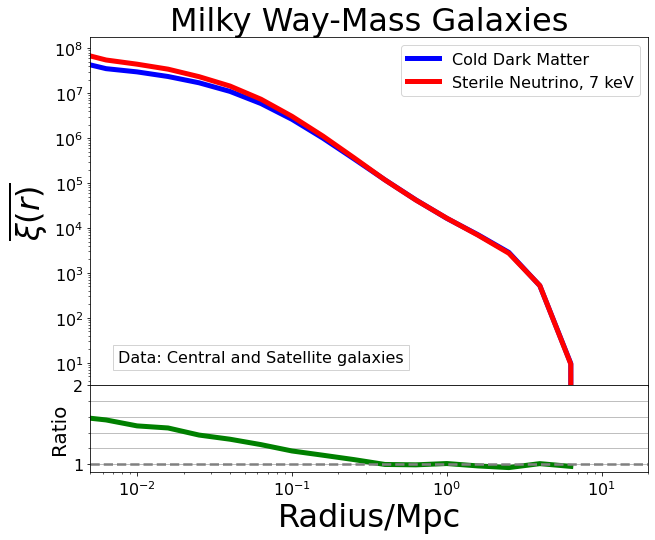

In [25]:
CUTE_cdm_galaxy = np.mean(shell_galaxy['cdm'], axis = 0)
CUTE_wdm_galaxy = np.mean(shell_galaxy['wdm'], axis = 0)

textstr = r'Data: Central and Satellite galaxies'
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.loglog(CUTE_cdm_galaxy[:,0], CUTE_cdm_galaxy[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
grid0.loglog(CUTE_wdm_galaxy[:,0], CUTE_wdm_galaxy[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red")
grid0.set_xlim(5*10**-3, 2e1)
grid0.set_ylim(10**0.5, 10**8.25)
grid0.set_ylabel(r"$\overline{\xi(r)}$", fontsize = 32)
grid0.legend(fontsize=16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.1, textstr, transform = grid0.transAxes, fontsize = 16, verticalalignment = 'top', bbox = props)
grid0.set_title('Milky Way-Mass Galaxies', fontsize = 32)

grid1.semilogx(CUTE_wdm_galaxy[:,0], CUTE_wdm_galaxy[:,1]/CUTE_cdm_galaxy[:,1], linewidth = 5, color = "green")
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio",  fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(5*10**-3, 2e1)
grid1.set_ylim(0.9, 2)
grid1.minorticks_on()
grid1.tick_params(labelsize = 16)
grid1.yaxis.grid(which = "both")

plt.savefig('Images/Summer2020/local_galaxy_position.pdf', bbox_inches = "tight")
plt.show()

<ipython-input-26-3f02ed19ede2>:24: RuntimeWarning: invalid value encountered in true_divide
  grid1.semilogx(CUTE_wdm_halo[:,0], CUTE_wdm_halo[:,1]/CUTE_cdm_halo[:,1], linewidth = 5, color = "green")


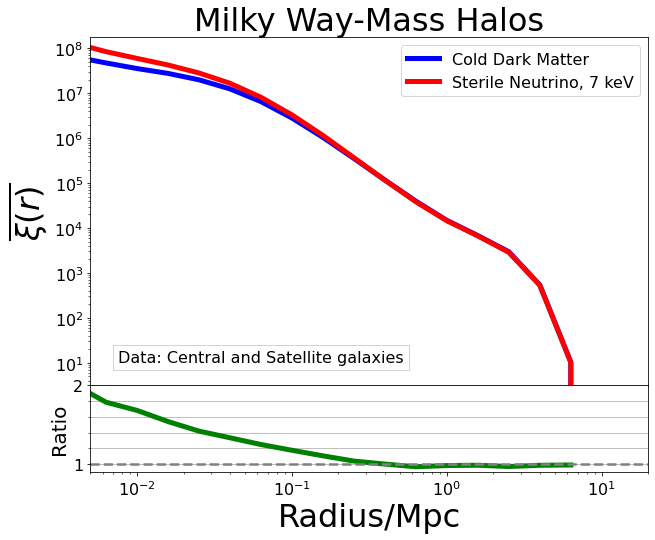

In [26]:
CUTE_cdm_halo = np.mean(shell_halo['cdm'], axis = 0)
CUTE_wdm_halo = np.mean(shell_halo['wdm'], axis = 0)

textstr = r'Data: Central and Satellite galaxies'
props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.loglog(CUTE_cdm_halo[:,0], CUTE_cdm_halo[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue")
grid0.loglog(CUTE_wdm_halo[:,0], CUTE_wdm_halo[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red")
grid0.set_xlim(5*10**-3, 2e1)
grid0.set_ylim(10**0.5, 10**8.25)
grid0.set_ylabel(r"$\overline{\xi(r)}$", fontsize = 32)
grid0.legend(fontsize=16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.1, textstr, transform = grid0.transAxes, fontsize = 16, verticalalignment = 'top', bbox = props)
grid0.set_title('Milky Way-Mass Halos', fontsize = 32)

grid1.semilogx(CUTE_wdm_halo[:,0], CUTE_wdm_halo[:,1]/CUTE_cdm_halo[:,1], linewidth = 5, color = "green")
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio",  fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(5*10**-3, 2e1)
grid1.set_ylim(0.9, 2)
grid1.minorticks_on()
grid1.tick_params(labelsize=16)
grid1.yaxis.grid(which = "both")

plt.savefig('Images/Summer2020/local_halo_position.pdf', bbox_inches = "tight")
plt.show()

### Now add error bars!

<ipython-input-27-2280d4b60793>:28: RuntimeWarning: invalid value encountered in true_divide
  grid1.errorbar(CUTE_wdm_galaxy[:,0], CUTE_wdm_galaxy[:,1]/CUTE_cdm_galaxy[:,1], linewidth = 5, color = "green",
<ipython-input-27-2280d4b60793>:29: RuntimeWarning: invalid value encountered in true_divide
  yerr = wdm_std/cdm_std, capsize = 5, capthick = 5)


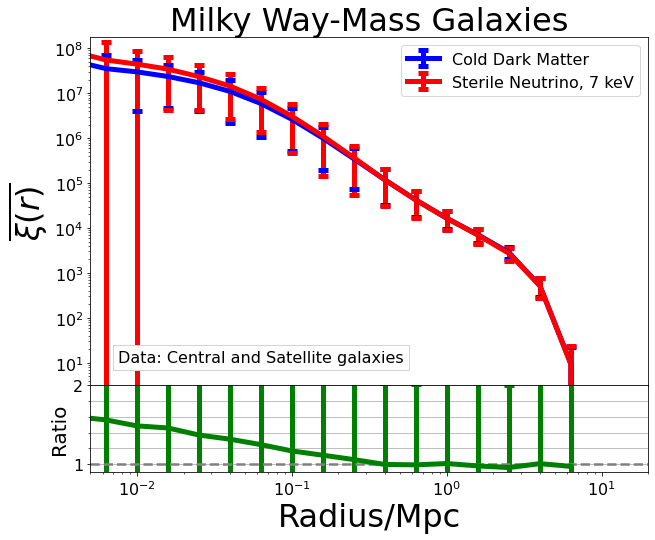

In [27]:
CUTE_cdm_galaxy, cdm_std = np.mean(shell_galaxy['cdm'], axis = 0), np.std(shell_galaxy['cdm'], axis = 0)[:,1]
CUTE_wdm_galaxy, wdm_std = np.mean(shell_galaxy['wdm'], axis = 0), np.std(shell_galaxy['wdm'], axis = 0)[:,1]

textstr = r'Data: Central and Satellite galaxies'
props = dict(facecolor='white', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.errorbar(CUTE_cdm_galaxy[:,0], CUTE_cdm_galaxy[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue", 
               yerr = cdm_std, capsize = 5, capthick = 5)
grid0.errorbar(CUTE_wdm_galaxy[:,0], CUTE_wdm_galaxy[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red", 
               yerr = wdm_std, capsize = 5, capthick = 5)
grid0.set_xlim(5*10**-3, 2e1)
grid0.set_ylim(10**0.5, 10**8.25)
grid0.set_ylabel(r"$\overline{\xi(r)}$", fontsize = 32)
grid0.legend(fontsize=16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.1, textstr, transform = grid0.transAxes, fontsize = 16, verticalalignment = 'top', bbox = props)
grid0.set_title('Milky Way-Mass Galaxies', fontsize = 32)
grid0.set_xscale('Log')
grid0.set_yscale('Log')

grid1.errorbar(CUTE_wdm_galaxy[:,0], CUTE_wdm_galaxy[:,1]/CUTE_cdm_galaxy[:,1], linewidth = 5, color = "green", 
               yerr = wdm_std/cdm_std, capsize = 5, capthick = 5)
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio",  fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(5*10**-3, 2e1)
grid1.set_ylim(0.9, 2)
grid1.minorticks_on()
grid1.tick_params(labelsize = 16)
grid1.yaxis.grid(which = "both")
grid1.set_xscale('Log')

plt.savefig('Images/Summer2020/local_galaxy_position_std.pdf', bbox_inches = "tight")
plt.show()

<ipython-input-28-c0d715125664>:28: RuntimeWarning: invalid value encountered in true_divide
  grid1.errorbar(CUTE_wdm_halo[:,0], CUTE_wdm_halo[:,1]/CUTE_cdm_halo[:,1], linewidth = 5, color = "green",
<ipython-input-28-c0d715125664>:29: RuntimeWarning: invalid value encountered in true_divide
  yerr = wdm_std/cdm_std, capsize = 5, capthick = 5)


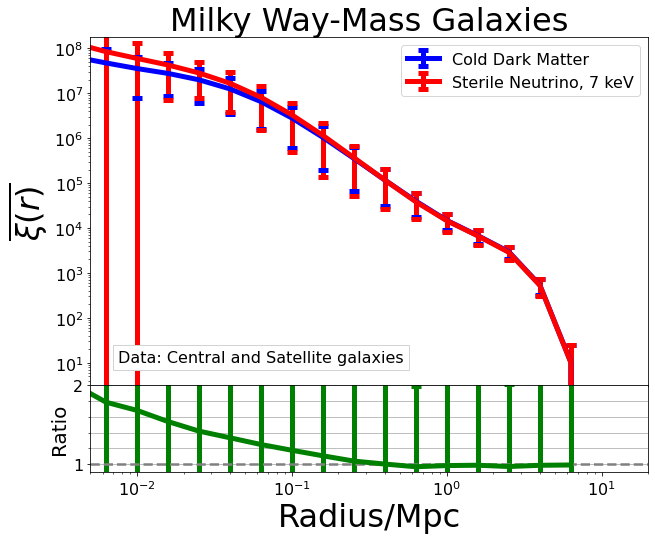

In [28]:
CUTE_cdm_halo, cdm_std = np.mean(shell_halo['cdm'], axis = 0), np.std(shell_halo['cdm'], axis = 0)[:,1]
CUTE_wdm_halo, wdm_std = np.mean(shell_halo['wdm'], axis = 0), np.std(shell_halo['wdm'], axis = 0)[:,1]

textstr = r'Data: Central and Satellite galaxies'
props = dict(facecolor='white', edgecolor='lightgrey', pad = 5.0)

plt.figure(figsize=(10,8))
grid = gridspec.GridSpec(2,1, height_ratios = [4,1])
grid.update(hspace = 0)
grid0 = plt.subplot(grid[0])
grid1 = plt.subplot(grid[1])

grid0.errorbar(CUTE_cdm_halo[:,0], CUTE_cdm_halo[:,1], label = "Cold Dark Matter", linewidth = 5, color = "blue", 
               yerr = cdm_std, capsize = 5, capthick = 5)
grid0.errorbar(CUTE_wdm_halo[:,0], CUTE_wdm_halo[:,1], label = "Sterile Neutrino, 7 keV", linewidth = 5, color = "red", 
               yerr = wdm_std, capsize = 5, capthick = 5)
grid0.set_xlim(5*10**-3, 2e1)
grid0.set_ylim(10**0.5, 10**8.25)
grid0.set_ylabel(r"$\overline{\xi(r)}$", fontsize = 32)
grid0.legend(fontsize=16)
grid0.minorticks_on()
grid0.tick_params(labelsize=16)
grid0.text(0.05, 0.1, textstr, transform = grid0.transAxes, fontsize = 16, verticalalignment = 'top', bbox = props)
grid0.set_title('Milky Way-Mass Galaxies', fontsize = 32)
grid0.set_xscale('Log')
grid0.set_yscale('Log')

grid1.errorbar(CUTE_wdm_halo[:,0], CUTE_wdm_halo[:,1]/CUTE_cdm_halo[:,1], linewidth = 5, color = "green", 
               yerr = wdm_std/cdm_std, capsize = 5, capthick = 5)
grid1.set_xlabel("Radius/Mpc", fontsize = 32)
grid1.set_ylabel("Ratio",  fontsize = 20)
grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
grid1.set_xlim(5*10**-3, 2e1)
grid1.set_ylim(0.9, 2)
grid1.minorticks_on()
grid1.tick_params(labelsize = 16)
grid1.yaxis.grid(which = "both")
grid1.set_xscale('Log')

plt.savefig('Images/Summer2020/local_halo_position_std.pdf', bbox_inches = "tight")
plt.show()